動画の総フレーム数: 364


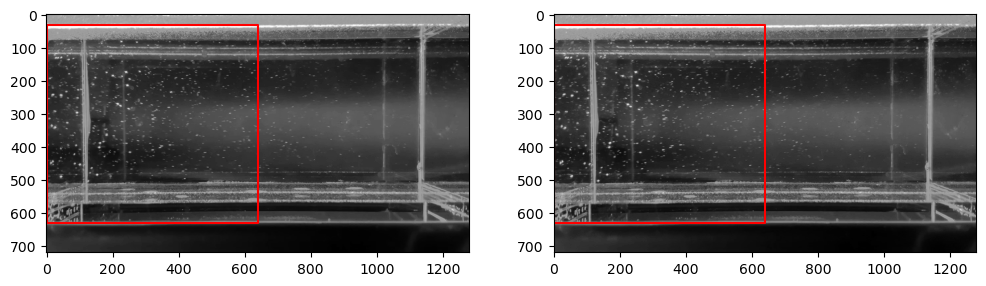

NameError: name 'frame_a_size' is not defined

In [5]:
import myPIV

# winsize, searchsize, overlap, fps, Nframes
myPiv = myPIV.myParticleImageVelocimetry('IMG_0404', 30, 40, 20, 30.0)
myPiv.movie_to_images('IMG_0404.MOV')

xmin, xmax = 0, int(1280*0.5)
ymin, ymax = 30, 630
myPiv.setAnalyzeRegion(xmin, xmax, ymin, ymax)

dy = myPiv.ymax - myPiv.ymin
myPiv.lengthScale = dy/50.0 # pixels per mm

#myPiv.run_analysis()

#myPiv.summarize()

In [121]:
import cv2
import numpy as np

# 動画ファイルのパス
video_name = 'IMG_0404'

# 1. 動画の読み込み
cap = cv2.VideoCapture(video_name+'.MOV')

if not cap.isOpened():
    print("動画が読み込めません。")
    exit()

# 2. フレーム数を取得
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"動画の総フレーム数: {total_frames}")

for frame_to_save in np.arange(1,101):
    # 3. 特定のフレームに移動
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_save)

    # 4. フレームの読み込み
    ret, frame = cap.read()

    # 5. 画像として保存
    output_image_path = video_name + f"/frame_{frame_to_save:04d}.png"
    cv2.imwrite(output_image_path, frame)
    #print(f"フレーム {frame_to_save} を {output_image_path} に保存しました。")

# 動画のリソースを解放
cap.release()



動画の総フレーム数: 364


In [2]:
from openpiv import tools, pyprocess, validation, filters, scaling

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import importlib_resources
import pathlib

Frame A のピクセルサイズ: 高さ 720 ピクセル, 幅 1280 ピクセル
Frame B のピクセルサイズ: 高さ 720 ピクセル, 幅 1280 ピクセル


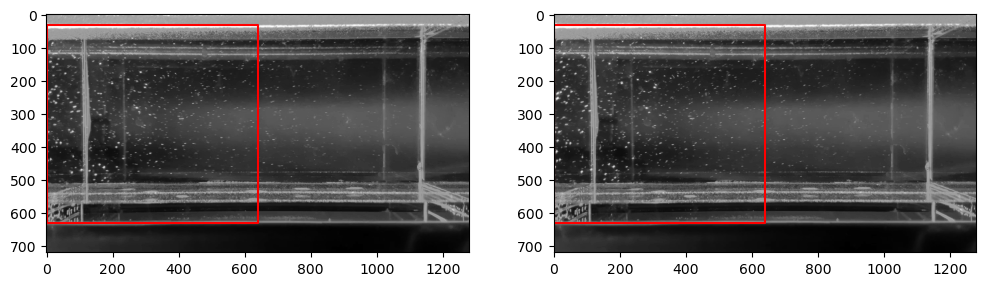

In [205]:
# 解析領域の設定
xmin, xmax = 0, int(1280*0.5)
ymin, ymax = 30, 630

frame_a_name = video_name + '/frame_0010.png' 
frame_b_name = video_name + '/frame_0011.png' 
frame_a  = tools.imread(frame_a_name)
frame_b  = tools.imread(frame_b_name)

# 画像のピクセルサイズを取得
frame_a_size = frame_a.shape
frame_b_size = frame_b.shape

x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)
#frame_a = frame_a[500:950, 250:1250]
#frame_b = frame_b[500:950, 250:1250]

fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)
ax[0].plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='r')
ax[1].plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='r')

print("Frame A のピクセルサイズ: 高さ {0} ピクセル, 幅 {1} ピクセル".format(frame_a_size[0], frame_a_size[1]))
print("Frame B のピクセルサイズ: 高さ {0} ピクセル, 幅 {1} ピクセル".format(frame_b_size[0], frame_b_size[1]))


In [241]:
winsize = 40 # pixels, interrogation window size in frame A
searchsize = 50  # pixels, search area size in frame B
overlap = 20 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

for i in np.arange(1,100):
    frame_a_name = video_name + '/frame_{:04d}.png'.format(i)
    frame_b_name = video_name + '/frame_{:04d}.png'.format(i+1)
    frame_a  = tools.imread(frame_a_name)
    frame_b  = tools.imread(frame_b_name)

    # 解析領域の設定 
    #frame_a = frame_a[ymin:ymax, xmin:xmax]
    #frame_b = frame_b[ymin:ymax, xmin:xmax]

    ##############################################################################
    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        frame_a.astype(np.int32),
        frame_b.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2mean',
    )

    x, y = pyprocess.get_coordinates(
        image_size=frame_a.shape,
        search_area_size=searchsize,
        overlap=overlap,
    )
    ##############################################################################

    #invalid_mask = validation.sig2noise_val(sig2noise, threshold = 1.05)
    u0_std = np.nanstd(u0)
    u0_mean = np.nanmean(u0)
    v0_std = np.nanstd(v0)
    v0_mean = np.nanmean(v0)
    #invalid_mask = validation.global_std(u0, v0, std_threshold = 1)
    invalid_mask = validation.global_val(u0, v0, [0, int(u0_mean+u0_std*1)], [0, int(v0_mean+v0_std*1)])
    u2, v2 = filters.replace_outliers(
        u0, v0,
        flags=invalid_mask,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )
    u2 = np.nan_to_num(u0, nan=0.0)
    v2 = np.nan_to_num(v0, nan=0.0)

    # convert
    x, y, u3, v3 = scaling.uniform(
        x, y, u2, v2,
        scaling_factor = 1,  # 96.52 pixels/millimeter
    )

    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)
    tools.save(video_name + '/{:04d}.txt'.format(i), x, y, u3, v3, invalid_mask)

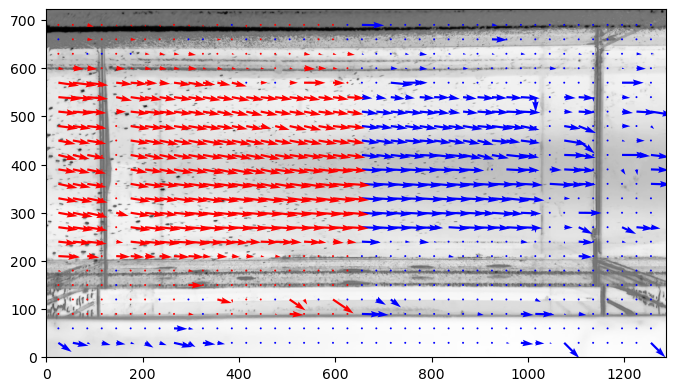

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image

# Load the data from the file
file_path = video_name + '/0001.txt'
data = np.loadtxt(file_path)
x, y, u, v, invalid_mask = data[:,0], data[:,1], data[:,2], data[:,3], (np.round((data[:,4]-1)*-1)).astype(int)


for i in np.arange(2,99):
    data = np.loadtxt(video_name + '/{:04d}.txt'.format(i))
    x1, y1, u1, v1, invalid_mask1 = data[:,0], data[:,1], data[:,2], data[:,3], (np.round((data[:,4]-1)*-1)).astype(int)
    u += u1 * invalid_mask1
    v += v1 * invalid_mask1
    invalid_mask += invalid_mask1
u /= invalid_mask.astype(float)+1e-10
v /= invalid_mask.astype(float)+1e-10

invalid_mask[invalid_mask>0] = 1
#invalid_mask[invalid_mask==0] = 1
invalid_mask[(x<xmin) | (x>xmax)] = 0
invalid_mask[(y>720-ymin) | (y<720-ymax)] = 0

fig, ax = plt.subplots(figsize=(8,8))
tools.save(video_name + 'sum.txt', x, y, u, v, invalid_mask)
tools.display_vector_field(
    pathlib.Path(video_name + 'sum.txt'),
    ax=ax, scaling_factor=1,
    scale=1e4, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    show_invalid=True,
    window_size = 64,
    on_img=True, # overlay on the image
    image_name= str(frame_a_name),
)

plt.show()


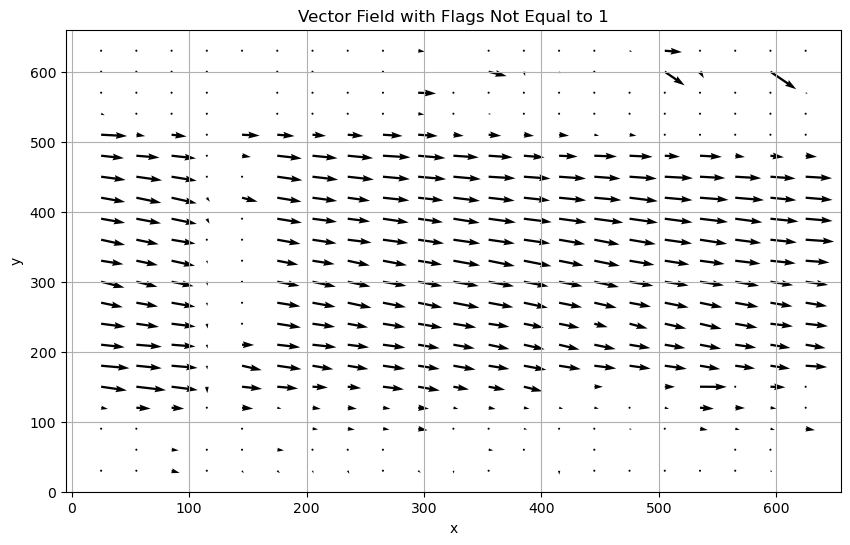

In [251]:
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルのパス
file_path = video_name + 'sum.txt'

# データを読み込む
df = pd.read_csv(file_path, delim_whitespace=True)

# flagsが1ではない行をフィルタリング
filtered_df = df[df['flags'] != 0]

# ベクトル場をプロット
plt.figure(figsize=(10, 6))
plt.quiver(filtered_df['x'], 720-filtered_df['y'], filtered_df['u'], filtered_df['v'], scale=1e4)
plt.title('Vector Field with Flags Not Equal to 1')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


In [246]:
filtered_df

,#,x,y,u,v,flags,mask
0,25.0,690.0,0.000,-0.000,1.0,0.0,NaN
1,55.0,690.0,14.676,-14.092,1.0,0.0,NaN
2,85.0,690.0,104.240,-28.947,1.0,0.0,NaN
3,115.0,690.0,16.440,-11.742,1.0,0.0,NaN
4,145.0,690.0,21.546,-33.728,1.0,0.0,NaN
...,...,...,...,...,...,...,...
961,1135.0,30.0,0.000,-0.000,0.0,0.0,NaN
962,1165.0,30.0,0.000,-0.000,0.0,0.0,NaN
963,1195.0,30.0,0.000,-0.000,0.0,0.0,NaN
964,1225.0,30.0,0.000,-0.000,0.0,0.0,NaN


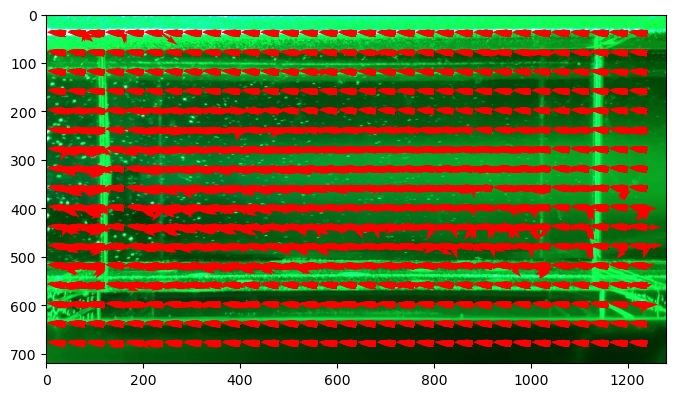

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pathlib

# Load the background image
frame_a_name = video_name + '/frame_0010.png' 

image = Image.open(frame_a_name)
image_array = np.asarray(image)

fig, ax = plt.subplots(figsize=(8,8))
# Display the image
ax.imshow(image_array, extent=[0, image.width, image.height, 0])

# Calculate the scaling factors if necessary
# You might need to adjust these values based on your specific setup
scaling_factor = 1   # adjust this based on your analysis region scale
scale = 1e4          # adjust the arrow length
width = 0.0035       # adjust the thickness of the arrow

# Load the PIV data and plot
for i in np.arange(2,99):
    data = np.loadtxt(video_name + f'/{i:04d}.txt')
    x, y, u, v, invalid_mask = data[:,0], data[:,1], data[:,2], data[:,3], (data[:,4]-1)*-1
    u_mean = np.mean(u[invalid_mask == 1])
    v_mean = np.mean(v[invalid_mask == 1])
    ax.quiver(x, y, u - u_mean, v - v_mean, scale=scale, color='red', width=width)

plt.show()




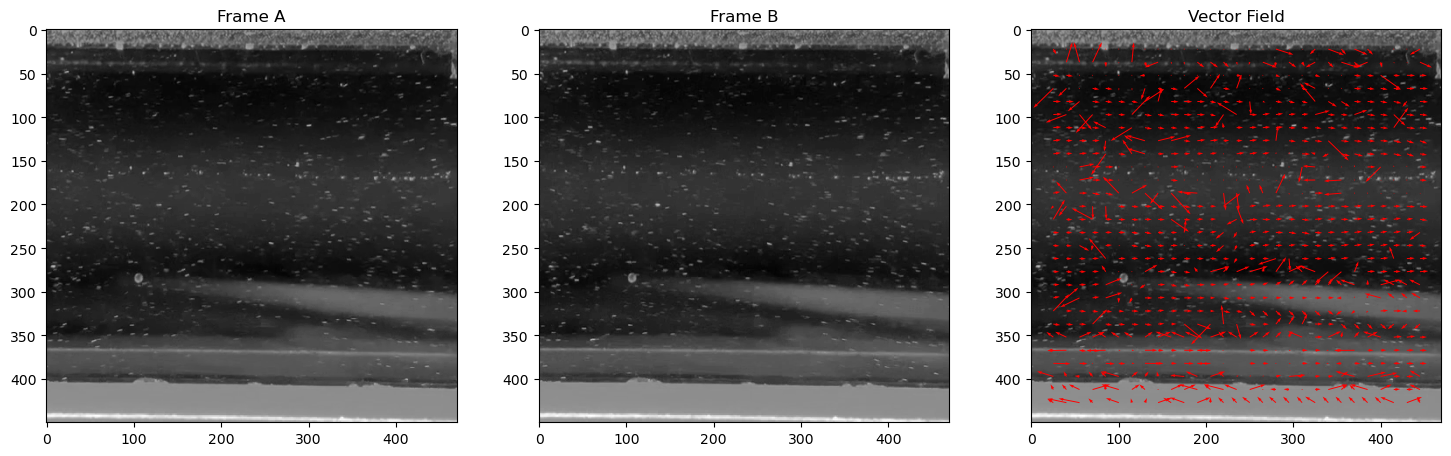

In [241]:
winsize = 30 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search area size in frame B
overlap = 25 # pixels, 50% overlap
dt = 0.02 # sec, time interval between the two frames

u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    frame_a.astype(np.int32),
    frame_b.astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
)

x, y = pyprocess.get_coordinates(
    image_size=frame_a.shape,
    search_area_size=searchsize,
    overlap=overlap,
)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(frame_a, cmap=plt.cm.gray)
ax[0].set_title('Frame A')
ax[1].imshow(frame_b, cmap=plt.cm.gray)
ax[1].set_title('Frame B')

# ベクトルフィールドのプロット
ax[2].imshow(frame_a, cmap=plt.cm.gray)
ax[2].quiver(x, y, u0, v0, color='r')
ax[2].set_title('Vector Field')

plt.show()


In [257]:
invalid_mask = validation.sig2noise_val(
    sig2noise,
    threshold = 1.5,
)

u2, v2 = filters.replace_outliers(
    u0, v0,
    invalid_mask,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(
    x, y, u2, v2,
    scaling_factor = 1,  # 96.52 pixels/millimeter
)

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

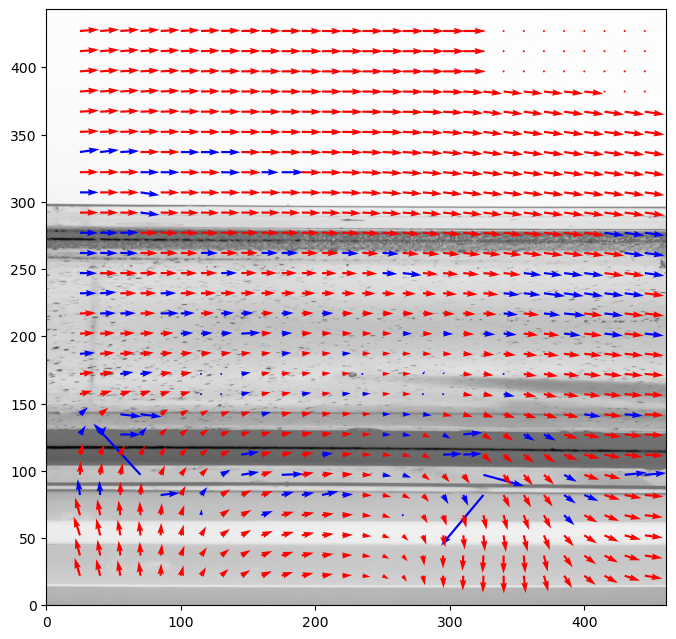

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [259]:
tools.save('exp1_001.txt' , x, y, u3, v3, invalid_mask)
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(
    pathlib.Path('exp1_001.txt'),
    ax=ax, scaling_factor=1,
    scale=10000, # scale defines here the arrow length
    width=0.0035, # width is the thickness of the arrow
    on_img=True, # overlay on the image
    image_name= str(frame_a_name),
)

In [152]:
u2

masked_array(
  data=[[-1.0271789 ,  3.44989519,  4.41685647, ..., 14.78081414,
         13.44344659, 12.43753691],
        [-1.0271789 ,  2.39903599,  3.49213041, ..., 14.66242723,
         13.35251746, 12.35463301],
        [-1.0271789 ,  1.76718776,  2.83238787, ..., 14.44340644,
         13.15195022, 12.16452816],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],
  mask=False,
  fill_value=1e+20)

In [268]:
for i in np.arange(1,20):
    frame_a_name = 'frame_{:04d}.png'.format(i)
    frame_b_name = 'frame_{:04d}.png'.format(i+1)
    frame_a  = tools.imread(frame_a_name)
    frame_b  = tools.imread(frame_b_name)

    # 解析領域の設定 (例: 画像の中心から200x200ピクセルの領域)
    frame_a = frame_a[500:950, 250:1250]
    frame_b = frame_b[500:950, 250:1250]

    #fig,ax = plt.subplots(1,2,figsize=(12,10))
    #ax[0].imshow(frame_a,cmap=plt.cm.gray)
    #ax[1].imshow(frame_b,cmap=plt.cm.gray)

    #frame_a_size = frame_a.shape
    #frame_b_size = frame_b.shape
    #print("Frame A のピクセルサイズ: 高さ {0} ピクセル, 幅 {1} ピクセル".format(frame_a_size[0], frame_a_size[1]))
    #print("Frame B のピクセルサイズ: 高さ {0} ピクセル, 幅 {1} ピクセル".format(frame_b_size[0], frame_b_size[1]))

    ##############################################################################
    winsize = 30 # pixels, interrogation window size in frame A
    searchsize = 40  # pixels, search area size in frame B
    overlap = 25 # pixels, 50% overlap
    dt = 0.02 # sec, time interval between the two frames

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        frame_a.astype(np.int32),
        frame_b.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2peak',
    )

    x, y = pyprocess.get_coordinates(
        image_size=frame_a.shape,
        search_area_size=searchsize,
        overlap=overlap,
    )

    ##############################################################################

    invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold = 1.5,
    )

    u2, v2 = filters.replace_outliers(
        u0, v0,
        invalid_mask,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )

    # convert x,y to mm
    # convert u,v to mm/sec

    x, y, u3, v3 = scaling.uniform(
        x, y, u2, v2,
        scaling_factor = 96.52,  # 96.52 pixels/millimeter
    )

    # 0,0 shall be bottom left, positive rotation rate is counterclockwise
    x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

    tools.save('exp1_{:04d}.txt'.format(i), x, y, u3, v3, invalid_mask)




    

ValueError: operands could not be broadcast together with shapes (812,40,21) (1820,40,21) 

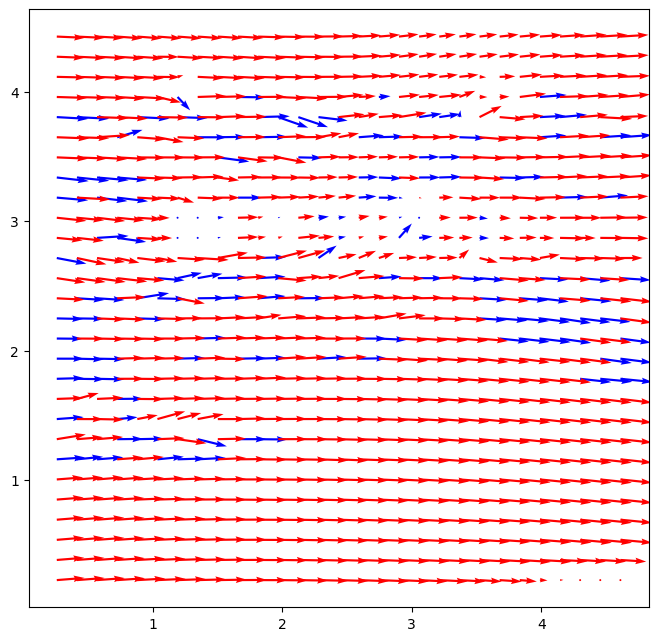

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [278]:
u[800]

48.329699999999995

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from openpiv import tools, pyprocess, validation, filters, scaling
import pathlib

# Initialize arrays to accumulate u and v velocities
cumulative_u = np.zeros((1000//20, 1000//20))  # Update shape according to your needs
cumulative_v = np.zeros((1000//20, 1000//20))  # Update shape according to your needs
n_images = 8  # Number of image pairs

for i in range(1, 9):
    frame_a_name = f'frame_001{i}.png'
    frame_b_name = f'frame_001{i+1}.png'
    frame_a = imread(frame_a_name)
    frame_b = imread(frame_b_name)

    # Process PIV using OpenPIV
    winsize = 20
    searchsize = 30
    overlap = 10  # usually a fraction of the window size
    dt = 0.02

    u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        frame_a.astype(np.int32),
        frame_b.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2peak'
    )

    # Validate and filter the results
    invalid_mask = validation.global_val(u0, v0, (-1000, 1000), (-1000, 1000))
    u0, v0 = validation.sig2noise_val(u0, v0, sig2noise, threshold=1.3)
    u2, v2 = filters.replace_outliers(u0, v0, invalid_mask, method='localmean', max_iter=3, kernel_size=2)

    # Accumulate results
    cumulative_u += u2
    cumulative_v += v2

# Average the results
average_u = cumulative_u / n_images
average_v = cumulative_v / n_images

# Visualization or saving the average flow fields
fig, ax = plt.subplots(figsize=(8, 8))
ax.quiver(average_u, average_v)
plt.show()


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

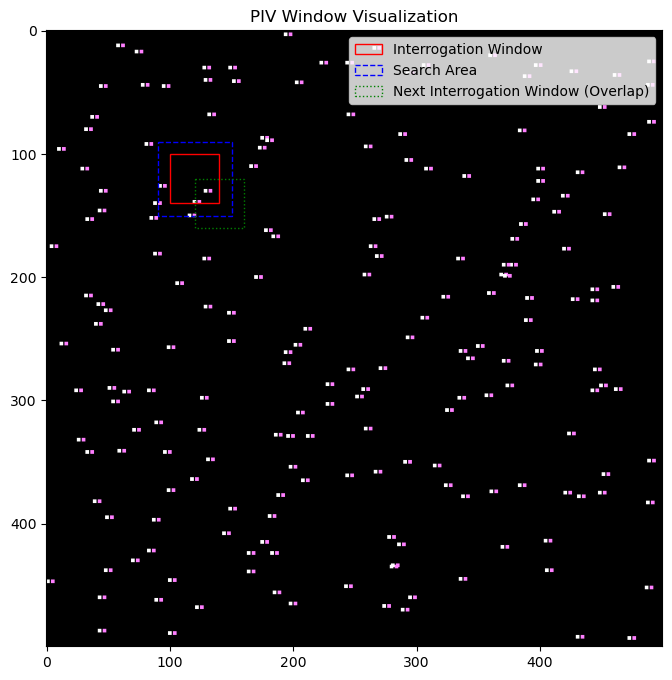

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 画像サイズと粒子の数
image_size = (500, 500)
num_particles = 200

# ダミー画像の生成
image = np.zeros((image_size[0], image_size[1], 3))

# ランダムな粒子の生成
np.random.seed(0)  # 再現性のためのシード設定
particles_x = np.random.randint(1, image_size[1]-5, num_particles)
particles_y = np.random.randint(1, image_size[0]-5, num_particles)
for x, y in zip(particles_x, particles_y):
    for i in range(3):
        for j in range(3):
            image[y + i - 1, x + j - 1] = [1, 1, 1]  # RGBのみ使用（アルファチャンネル除外）
            
    for i in range(3):
        for j in range(3):
            image[y + i + -1, x + j + 3] = [1, 0.5, 1]  # RGBのみ使用（アルファチャンネル除外）



# PIVパラメータ
window_size = 40  # Interrogation window size
search_size = 60  # Search area size
overlap = 20      # 50% overlap

# 描画設定
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(image)
ax.set_title('PIV Window Visualization')

# 初期位置
start_x, start_y = 100, 100  # 適当な開始点

# Interrogation window 描画
interrogation_rect = patches.Rectangle(
    (start_x, start_y), window_size, window_size,
    linewidth=1, edgecolor='r', facecolor='none', label='Interrogation Window')
ax.add_patch(interrogation_rect)

# Search area 描画
search_rect = patches.Rectangle(
    (start_x + window_size / 2 - search_size / 2, start_y + window_size / 2 - search_size / 2),
    search_size, search_size,
    linewidth=1, edgecolor='blue', facecolor='none', linestyle='--', label='Search Area')
ax.add_patch(search_rect)

# Overlapping area 描画 (次のウィンドウ)
next_start_x = start_x + window_size - overlap
next_start_y = start_y + window_size - overlap
next_interrogation_rect = patches.Rectangle(
    (next_start_x, next_start_y), window_size, window_size,
    linewidth=1, edgecolor='green', facecolor='none', linestyle=':', label='Next Interrogation Window (Overlap)')
ax.add_patch(next_interrogation_rect)

# 凡例の追加
ax.legend()

plt.show()


C:\Users\tamadate\AppData\Local\Temp\ipykernel_40412\1410020685.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("spring")  # カラーマップの選択


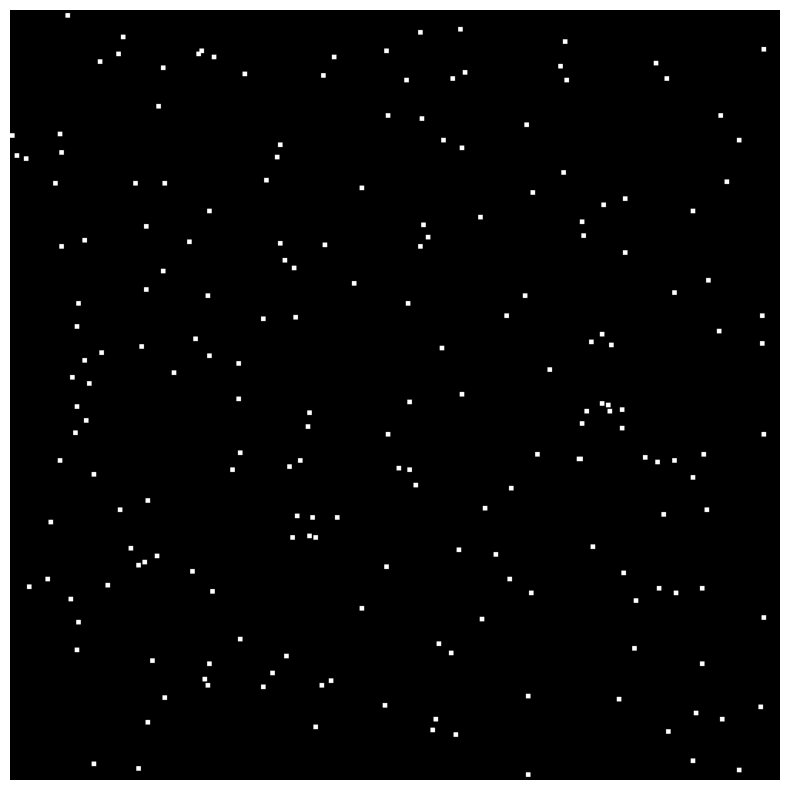

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# 画像サイズと粒子の数
image_size = (500, 500)
num_particles = 200

# カラー画像の生成（3チャネル：RGB）
color_image = np.zeros((image_size[0], image_size[1], 3))

# ランダムな粒子の生成
np.random.seed(0)  # 再現性のためのシード設定
particles_x = np.random.randint(1, image_size[1]-3, num_particles)
particles_y = np.random.randint(1, image_size[0]-3, num_particles)

# カラーマップの準備
norm = Normalize(vmin=0, vmax=num_particles - 1)
cmap = cm.get_cmap("spring")  # カラーマップの選択
colors = cmap(norm(range(num_particles)))  # 各粒子に色を割り当て

# 粒子を色付きで画像に追加
for x, y, color in zip(particles_x, particles_y, colors):
    for i in range(3):  # 粒子のサイズ3x3ピクセル
        for j in range(3):
            color_image[y + i - 1, x + j - 1] = [1, 1, 1]  # RGBのみ使用（アルファチャンネル除外）

# 描画設定
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(color_image)
ax.axis('off')  # 軸の非表示
plt.show()


In [39]:
colors

array([[1.        , 0.        , 1.        , 1.        ],
       [1.        , 0.00392157, 0.99607843, 1.        ],
       [1.        , 0.00784314, 0.99215686, 1.        ],
       [1.        , 0.01176471, 0.98823529, 1.        ],
       [1.        , 0.01960784, 0.98039216, 1.        ],
       [1.        , 0.02352941, 0.97647059, 1.        ],
       [1.        , 0.02745098, 0.97254902, 1.        ],
       [1.        , 0.03529412, 0.96470588, 1.        ],
       [1.        , 0.03921569, 0.96078431, 1.        ],
       [1.        , 0.04313725, 0.95686275, 1.        ],
       [1.        , 0.04705882, 0.95294118, 1.        ],
       [1.        , 0.05490196, 0.94509804, 1.        ],
       [1.        , 0.05882353, 0.94117647, 1.        ],
       [1.        , 0.0627451 , 0.9372549 , 1.        ],
       [1.        , 0.07058824, 0.92941176, 1.        ],
       [1.        , 0.0745098 , 0.9254902 , 1.        ],
       [1.        , 0.07843137, 0.92156863, 1.        ],
       [1.        , 0.08235294,

In [1]:
import cv2
import numpy as np
from openpiv import tools, pyprocess, validation, filters, scaling

# ビデオファイルの読み込み
cap = cv2.VideoCapture('input_video.mp4')

# フレームを読み込む
ret, frame_a = cap.read()
frame_a_gray = cv2.cvtColor(frame_a, cv2.COLOR_BGR2GRAY)

# 各フレームごとにPIV処理を行う
while True:
    ret, frame_b = cap.read()
    if not ret:
        break
    
    frame_b_gray = cv2.cvtColor(frame_b, cv2.COLOR_BGR2GRAY)
    
    # PIV解析の設定from openpiv import tools, pyprocess, validation, filters, scaling

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import imageio
import importlib_resources
import pathlib
    u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a_gray, frame_b_gray, window_size=24, overlap=12, dt=0.02, search_area_size=64, sig2noise_method='peak2peak')
    
    # ベクトルの検証とフィルタリング
    u, v, mask = validation.sig2noise_val(u, v, sig2noise, threshold=1.3)
    u, v = filters.replace_outliers(u, v, method='localmean', max_iter=10, kernel_size=2)
    
    # ベクトル場のスケーリング（実際の単位へ変換）
    x, y, u, v = scaling.uniform(u, v, scaling_factor=96.52)
    
    # ベクトル場の描画
    tools.display_vector_field('output.vec', scale=100, width=0.0025)
    
    # 次のフレームを準備
    frame_a_gray = frame_b_gray

cap.release()

print("PIV解析が完了しました。")


TypeError: sig2noise_val() got multiple values for argument 'threshold'

In [ ]:
# 解析パラメータ
window_size = 32  # ピクセル単位のウィンドウサイズ
overlap = 16      # ピクセル単位のウィンドウの重なり

# 前のフレームを保持する変数
ret, prev_frame = cap.read()
if not ret:
    print("動画の最初のフレームが読み込めません。")
    cap.release()
    exit()

prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# フレーム解析ループ
frame_index = 1
while cap.isOpened():
    ret, curr_frame = cap.read()
    if not ret:
        break

    curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    # 2. PIV解析
    u, v, sig2noise = pyprocess.extended_search_area_piv(
        prev_frame_gray.astype(np.int32),
        curr_frame_gray.astype(np.int32),
        window_size=window_size,
        overlap=overlap,
        dt=dt,
        search_area_size=window_size
    )

    # 3. 座標系の生成
    x, y = pyprocess.get_coordinates(
        image_size=prev_frame_gray.shape,
        window_size=window_size,
        overlap=overlap
    )

    # 4. 結果の検証とフィルタリング
    u, v = validation.sig2noise_val(u, v, sig2noise, threshold=1.3)
    u, v = filters.replace_outliers(u, v, method='localmean', max_iter=3, kernel_size=2)

    # 5. ベクトル場のプロット
    plt.figure(figsize=(10, 7))
    plt.quiver(x, y, u, v, scale=50, color='r')  # ベクトル場の描画
    plt.title(f'PIV Velocity Field - Frame {frame_index}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(f'output_frame_{frame_index:04d}.png')  # 結果を保存
    plt.close()

    # 次のフレームを準備
    prev_frame_gray = curr_frame_gray
    frame_index += 1

# 動画のリソースを解放
cap.release()
print("PIV解析が完了しました。結果は画像として保存されています。")


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from openpiv import tools, pyprocess, validation, filters

# 動画ファイルのパス
video_path = 'input_video.mp4'

# 解析するフレームの範囲を指定
start_frame = 1000  # 開始フレーム番号
end_frame = 1001   # 終了フレーム番号

# 動画の読み込み
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("動画が読み込めません。")
    exit()

# 動画の総フレーム数を取得
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
dt = 1 / fps  # フレーム間の時間間隔

if start_frame >= frame_count or end_frame >= frame_count:
    print("指定したフレーム範囲が動画のフレーム数を超えています。")
    cap.release()
    exit()

# 開始フレームにシーク
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# 解析パラメータ
window_size = 32  # ピクセル単位のウィンドウサイズ
overlap = 16      # ピクセル単位のウィンドウの重なり

# フレーム解析ループ
frame_index = start_frame
ret, prev_frame = cap.read()
if not ret:
    print("指定した開始フレームが読み込めません。")
    cap.release()
    exit()

prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

while cap.isOpened() and frame_index < end_frame:
    ret, curr_frame = cap.read()
    if not ret:
        break

    curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

    # PIV解析
    u, v, sig2noise = pyprocess.extended_search_area_piv(
        prev_frame_gray.astype(np.int32),
        curr_frame_gray.astype(np.int32),
        window_size=window_size,
        overlap=overlap,
        dt=dt,
        search_area_size=window_size
    )

    # 座標系の生成
    x, y = pyprocess.get_coordinates(
        image_size=prev_frame_gray.shape,  # フレームのサイズ
        search_area_size=32,               # 検索エリアサイズ（解析ウィンドウと同じ場合が多い）
        overlap=overlap                    # ウィンドウのオーバーラップ量
    )

    # 結果の検証とフィルタリング
    u, v = validation.sig2noise_val(u, v, sig2noise, threshold=1.3)
    u, v = filters.replace_outliers(u, v, method='localmean', max_iter=3, kernel_size=2)

    # ベクトル場のプロット
    plt.figure(figsize=(10, 7))
    plt.quiver(x, y, u, v, scale=50, color='r')  # ベクトル場の描画
    plt.title(f'PIV Velocity Field - Frame {frame_index}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.savefig(f'output_frame_{frame_index:04d}.png')  # 結果を保存
    plt.close()

    # 次のフレームへ
    prev_frame_gray = curr_frame_gray
    frame_index += 1

# 動画のリソースを解放
cap.release()
print(f"フレーム {start_frame} から {end_frame} の PIV解析が完了しました。")


TypeError: sig2noise_val() takes from 1 to 2 positional arguments but 3 were given